In [1]:
import itertools
import random
import numpy as np
import pandas as pd
import seaborn as sns
import cvxpy as cp
from tqdm import tqdm

from scipy.spatial import distance
from cvxpy.error import SolverError
from cvxpy import ECOS, SCS
import seaborn as sns
import ot
from pgmpy import inference
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

import scipy.optimize as optimize
from scipy.spatial.distance import cdist
from src.examples import smokingmodels as sm
from scipy.spatial.distance import squareform,pdist
from scipy.stats import wasserstein_distance

from scipy.optimize import linprog
from scipy import stats
from IPython.utils import io
import warnings

import joblib
import modularized_utils as ut
import abstraction_metrics as ams
import matplotlib.pylab as pl
import evaluation as eva

import get_results
import params

np.random.seed(0)

warnings.filterwarnings(action='ignore')
np.set_printoptions(precision=4,suppress=True)

In [2]:
def leave_one_out(pairs, dropped_pair, experiment, mode):
    
    omega = {}
    for pair in pairs:
        omega[pair.iota_base] = pair.iota_abst
    
    hold_pairs = pairs.copy()
   
    if dropped_pair != None:
        hold_pairs.remove(dropped_pair)
        hold_omega  = ut.drop1omega(omega, dropped_pair.iota_base)
        
    else:
        hold_omega = omega
        
    I_relevant  = list(hold_omega.keys())

    struc, tree = ut.build_poset(I_relevant)
    chains      = ut.to_chains(hold_pairs, struc)
    
    args   = [hold_pairs, [chains], params.lmbdas[experiment]]
    
    get_results.results(mode, args, experiment, dropped_pair)
    
    looo_results = ut.load_results(mode, experiment, dropped_pair)
    
    return looo_results

In [3]:
mode  = 'cota'
exp   = params.experiments[1]
pairs = ut.load_pairs(exp)


looo_results = []

for n in tqdm(range(len(pairs))):
    
    results = {}
    for i, pair in enumerate(pairs[n]):
        
        if pair.iota_base.intervention != {None: None}:
            dropped_pair = pair
        else:
            dropped_pair = None
            
        results[dropped_pair] = leave_one_out(pairs[n], dropped_pair, exp, mode)
        
    looo_results.append(results)

    print( )

  5%|██▏                                         | 1/20 [00:02<00:49,  2.59s/it]

 10%|████▍                                       | 2/20 [00:05<00:46,  2.59s/it]

 15%|██████▌                                     | 3/20 [00:07<00:44,  2.59s/it]

 20%|████████▊                                   | 4/20 [00:10<00:41,  2.58s/it]

 25%|███████████                                 | 5/20 [00:12<00:38,  2.57s/it]

 30%|█████████████▏                              | 6/20 [00:15<00:36,  2.59s/it]

 35%|███████████████▍                            | 7/20 [00:18<00:33,  2.61s/it]

 40%|█████████████████▌                          | 8/20 [00:20<00:31,  2.62s/it]

 45%|███████████████████▊                        | 9/20 [00:23<00:29,  2.64s/it]

 50%|█████████████████████▌                     | 10/20 [00:26<00:26,  2.62s/it]

 55%|███████████████████████▋                   | 11/20 [00:28<00:23,  2.63s/it]

 60%|█████████████████████████▊                 | 12/20 [00:31<00:21,  2.63s/it]

 65%|███████████████████████████▉               | 13/20 [00:33<00:18,  2.62s/it]

 70%|██████████████████████████████             | 14/20 [00:36<00:15,  2.59s/it]

 75%|████████████████████████████████▎          | 15/20 [00:39<00:12,  2.58s/it]

 80%|██████████████████████████████████▍        | 16/20 [00:41<00:10,  2.59s/it]

 85%|████████████████████████████████████▌      | 17/20 [00:44<00:07,  2.59s/it]

 90%|██████████████████████████████████████▋    | 18/20 [00:46<00:05,  2.58s/it]

 95%|████████████████████████████████████████▊  | 19/20 [00:49<00:02,  2.59s/it]

100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.60s/it]

In [4]:
n_sims    = len(looo_results)
lambdas   = list(looo_results[0][None]['cota'][0].keys())

metrics   = list(looo_results[0][None]['cota'][0][lambdas[0]])
mappings  = list(looo_results[0][None]['cota'][0][lambdas[0]][metrics[0]])
averaging = list(looo_results[0][None]['cota'][0][lambdas[0]][metrics[0]][mappings[0]])
costs     = list(looo_results[0][None]['cota'][0][lambdas[0]][metrics[0]][mappings[0]][averaging[0]])

len_sets  = len(metrics)*len(mappings)*len(averaging)*len(costs)

strings = []
for metric in metrics:
    for mapping in mappings:
        for average in averaging:
            for cost in costs:
                strings.append('{0}-{1}-{2}-{3}'.format(metric,mapping,average,cost))

# Make the results keys same with the pairs-to-evaluate                
for n in range(n_sims):    
    looo_results[n] = dict(zip(pairs[n], looo_results[n].values()))

In [5]:
equiv = {}
equiv['fro-stochastic-avg-Omega']    = 'D = FRO, C = ω'
equiv['fro-stochastic-avg-Hamming']  = 'D = FRO, C = H'
equiv['fro-stochastic-wavg-Omega']   = 'fro-ω'
equiv['fro-stochastic-wavg-Hamming'] = 'fro-H'
equiv['jsd-stochastic-avg-Omega']    = 'D = JSD, C = ω'
equiv['jsd-stochastic-avg-Hamming']  = 'D = JSD, C = H'
equiv['jsd-stochastic-wavg-Omega']   = 'jsd-ω'
equiv['jsd-stochastic-wavg-Hamming'] = 'jsd-H'

In [6]:
def averages(results, lambdas):
    
    results_m, results_s = {}, {}
    for k, res_lambda in enumerate(results):
        res_mean = np.mean(res_lambda,axis = 1)
        res_std  = np.std(res_lambda, axis = 1)

        results_m[lambdas[k]] = res_mean
        results_s[lambdas[k]] = res_std
    
    return results_m, results_s

def create_setting(results_lambdas, lambdas, setting):
    
    means, stds = averages(results_lambdas, lambdas)
    
    ae_mean, ae_std = {}, {}
    for key in list(means.keys()):
        ae_mean[key] = dict(zip(strings, means[key]))
        ae_std[key]  = dict(zip(strings, stds[key]))
        
    if setting == 'all':
        return ae_mean, ae_std
    else:
        mean_dict, std_dict = {}, {}
        for key in list(means.keys()):
            mean_dict[key] = select_setting(ae_mean[key], setting)
            std_dict[key]  = select_setting(ae_std[key], setting)
    
        return mean_dict, std_dict

def select_setting(data_dict, keywords):
    
    filtered_dict = {}
    for key, value in data_dict.items():
        key_parts = key.split('-')
        if all(keyword in key_parts for keyword in keywords):
            filtered_dict[key] = value
            
    return filtered_dict

In [7]:
def plot_setting(results_m, results_s, setting, show_error=True):
    lambdas = list(results_m.keys())

    palette = sns.color_palette("husl", n_colors=len(results_m[lambdas[0]]))

    plt.figure(figsize=(8.5, 6))

    for i in range(len(results_m[lambdas[0]])):
        y = [list(results_m[l].values())[i] for l in lambdas]
        x = lambdas
        error = [list(results_s[l].values())[i] for l in lambdas]

        if show_error:
            label = equiv[list(results_s[lambdas[0]].keys())[i]]
            color = palette[i]

            # Plot the line
            sns.lineplot(x=x, y=y, marker='o', label=label, alpha=0.7, color=color)

            # Fill the area between the upper and lower bounds of the error bars
            plt.fill_between(x, [y_i - e_i for y_i, e_i in zip(y, error)], [y_i + e_i for y_i, e_i in zip(y, error)], color=color, alpha=0.2)
        else:
            label = list(results_s[lambdas[0]].keys())[i]

            sns.lineplot(x=x, y=y, marker='o', label=label, alpha=0.7, color=palette[i])

    plt.xlabel('λ', fontsize=22)
    plt.ylabel('e(τ)', fontsize=22)
    plt.legend(loc='upper right', ncol=1, borderaxespad=1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.title('{} for {}'.format(exp, setting))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    return


In [8]:
def plot_setting1(results_m, results_s, setting, show_error = True):
    
    lambdas = list(results_m.keys())

    fig, ax = plt.subplots(figsize=(8.5, 6))

    for i in range(len(results_m[lambdas[0]])):
        y = [list(results_m[l].values())[i] for l in lambdas]
        x = lambdas
        error = [list(results_s[l].values())[i] for l in lambdas]
        
        if show_error == True:
            plt.errorbar(x, y, yerr=error, fmt='o-', label=equiv[list(results_s[lambdas[0]].keys())[i]], alpha=0.7)
        else:
            plt.errorbar(x, y, fmt='o-', label=list(results_s[lambdas[0]].keys())[i], alpha=0.7)

    
    plt.xlabel('λ', fontsize=22)
    plt.ylabel('e(τ)', fontsize=22)
    plt.legend(loc='upper right', ncol=1, borderaxespad=1)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.title('{} for {}'.format(exp, setting))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    
    return

def vis_lambda(results_lambdas, lambdas, setting):
    
    mean_set, std_set = create_setting(results_lambdas, lambdas, setting)
    
    if setting == 'all':
        plot_setting(mean_set, std_set, setting)
    else:
        plot_setting(mean_set, std_set, setting)
    
    return mean_set, std_set

In [9]:
def plot_metrics(map_results, setting, metric, error_dist, eval_method = None, golds = None):
    
    if metric == 'ae':
        
        if eval_method == 'looo':
            
            results = compute_ae_looo(map_results, error_dist)
            
        elif eval_method == 'acc':
            
            no_drop_results = []
            for i in range(len(map_results)):
                no_drop_results.append(map_results[i][list(map_results[i].keys())[0]]['cota'][0])
            
            results = compute_ae(no_drop_results, error_dist)
        
        results_lambas = list(results.values())
        lmbdas         = list(results.keys())
        
        m, s = vis_lambda(results_lambas, lmbdas, setting)
        
    elif metric == 'gt':
        
        results = compute_gt(map_results, golds)
        
        results_lambas = list(results.values())
        lmbdas         = list(results.keys())
        
        m, s = vis_lambda(results_lambas, lmbdas, setting)

    return m, s 

# COTA

In [10]:
def compute_ae(maps, error):
    
    results_mat_lambdas = []
    res_lam = {}

    n_sims = len(maps)
    lmbdas = list(maps[0].keys())

    for lmbda in lmbdas:

        results_mat = np.zeros((len_sets, n_sims))

        for n in range(n_sims):
            j = 0
            for metric in metrics:
                for mapping in mappings:
                    for average in averaging:
                        for cost in costs:
                            abstraction = ams.to_tuples(maps[n][lmbda][metric][mapping][average][cost], mapping)
                            num_pairs, ae = 0, 0
                            processed = []
                            
                            for pair in pairs[n]:
                                tau = ams.to_tuples(maps[n][lmbda][metric][mapping][average][cost], mapping)
                                if mapping != 'stochastic':
                                    pushforward = ams.discrete_pushforward(tau, pair.base_dict, list(pair.abst_dict.keys()))
                                else:
                                    pushforward = ams.stochastic_pushforward(tau, pair.base_dict, list(pair.abst_dict.keys()))
                                if error == 'jsd':
                                    ae += distance.jensenshannon(pushforward, pair.abst_distribution)
                                elif error == 'wass':
                                    ae +=wasserstein_distance(pushforward, pair.abst_distribution)
                            results_mat[j][n] = ae/len(pairs[n])
                            j += 1               
        results_mat_lambdas.append(results_mat)
        
    finals = {}
    for i, l in enumerate(lmbdas):
        finals[l] = results_mat_lambdas[i]
        
    return finals #results_mat_lambdas


In [11]:
def compute_ae_looo(maps, error):

    mode = 'cota'
    results_mat_lambdas = []
    res_lam = {}

    for lmbda in lambdas:

        results_mat = np.zeros((len_sets, n_sims))

        for n in range(n_sims):
            j = 0
            for metric in metrics:
                for mapping in mappings:
                    for average in averaging:
                        for cost in costs:
                            ae = 0
                            for pair in pairs[n]:
                                tau = ams.to_tuples(maps[n][pair][mode][0][lmbda][metric][mapping][average][cost], mapping)
                                if mapping != 'stochastic':
                                    pushforward = ams.discrete_pushforward(tau, pair.base_dict, list(pair.abst_dict.keys()))
                                else:
                                    pushforward = ams.stochastic_pushforward(tau, pair.base_dict, list(pair.abst_dict.keys()))
                                if error == 'jsd':
                                    ae += distance.jensenshannon(pushforward, pair.abst_distribution)
                                elif error == 'wass':
                                    ae +=wasserstein_distance(pushforward, pair.abst_distribution)
                            results_mat[j][n] = ae/len(pairs[n])
                            j += 1
        results_mat_lambdas.append(results_mat)

    finals = {}
    for i, l in enumerate(lambdas):
        finals[l] = results_mat_lambdas[i]

    return finals
                                                   

# ACCURACY

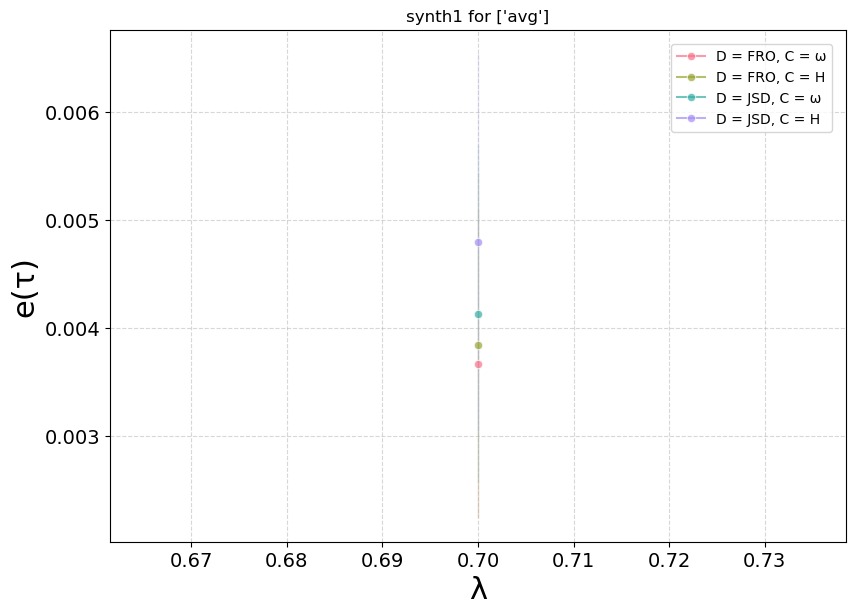

In [12]:
means, stds = plot_metrics(
                           map_results = looo_results,
                           setting     = ['avg'],
                           metric      = 'ae',
                           eval_method = 'acc',
                           error_dist  = 'wass'
                          )

# LOOO

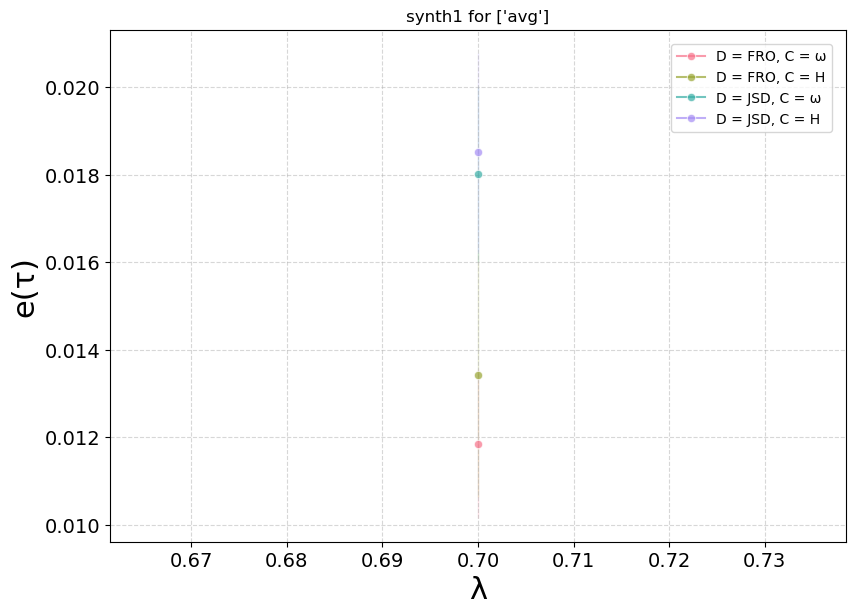

In [13]:
means, stds = plot_metrics(
                           map_results = looo_results,
                           setting     = ['avg'],
                           metric      = 'ae',
                           eval_method = 'looo',
                           error_dist  = 'wass'
                          )